In [ ]:
import os
import numpy as np
import pandas as pd

from glob import glob
from PIL import Image
from collections import Counter

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization,Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
# Setting data directory
data_directory = os.path.join("../images/")
os.listdir(data_directory)
# Loading HAM10000_meatdata.csv
df = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

In [ ]:
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())
# Adding cell_type and image_path columns
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['path'] = df['image_id'].map(imageid_path_dict.get)


# Adding image pixels
df['image_pixel'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
4368,HAM_0000276,ISIC_0029864,nv,follow_up,40.0,female,trunk,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[230, 149, 149], [233, 150, 153], [233, 148,..."
9483,HAM_0007478,ISIC_0033040,nv,consensus,30.0,male,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[176, 146, 164], [186, 158, 177], [193, 161,..."
260,HAM_0001309,ISIC_0034037,bkl,histo,60.0,female,lower extremity,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[187, 166, 182], [195, 177, 195], [202, 186,..."
6847,HAM_0004747,ISIC_0031435,nv,histo,55.0,female,unknown,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[142, 119, 135], [143, 120, 136], [142, 119,..."
6298,HAM_0006293,ISIC_0027314,nv,follow_up,60.0,male,trunk,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[239, 166, 176], [248, 179, 188], [248, 184,..."


In [ ]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=df['sex'].value_counts().index,
            y=df['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=df['localization'].value_counts().index,
            y=df['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=df['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=df['dx'].value_counts().index.map(lesion_type_dict.get),
            y=df['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

<ipython-input-7-ef724403429a>:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-7-ef724403429a>:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-7-ef724403429a>:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



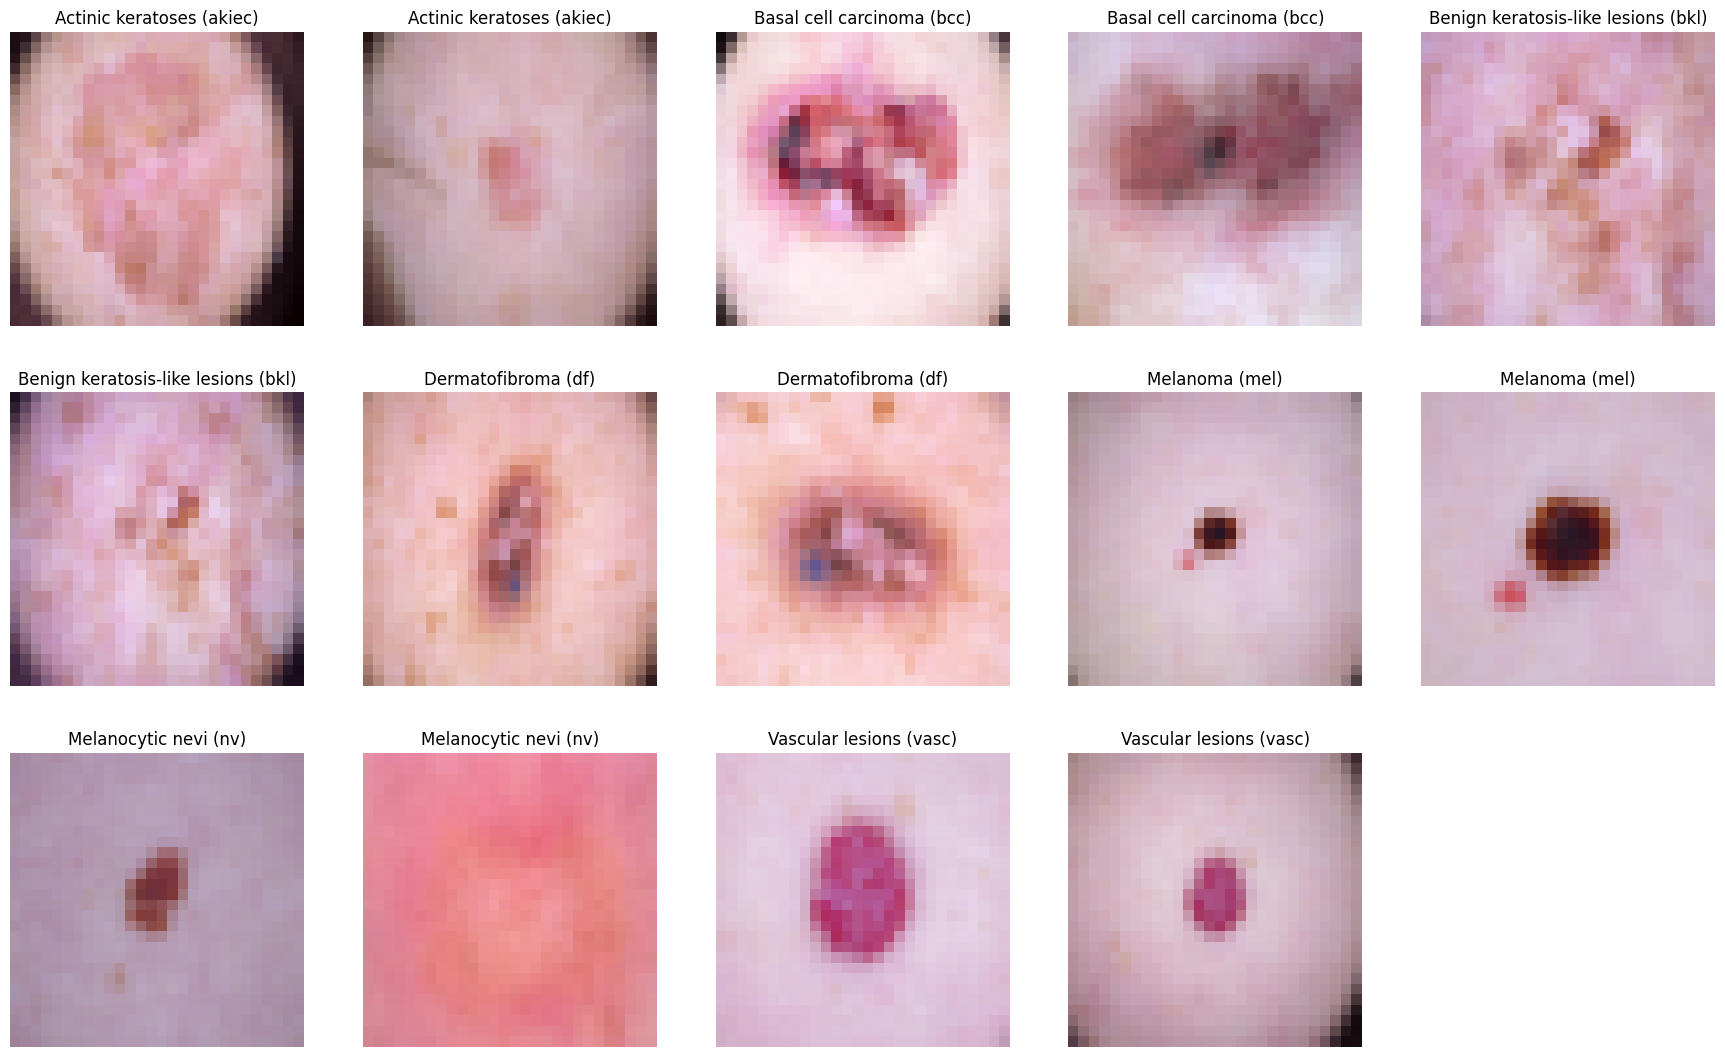

In [ ]:
# Displaying 2 images for each label
sample_data = df.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.6+ KB


In [ ]:
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
cell_type,0
path,0
image_pixel,0


In [ ]:
df['age'].fillna(value=int(df['age'].mean()), inplace=True)
# Converting dtype of age to int32
df['age'] = df['age'].astype('int32')
# Categorically encoding label of the images
df['label'] = df['dx'].map(reverse_label_mapping.get)
df.sample(5)

<ipython-input-10-f2fccf2f34b1>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
8745,HAM_0004802,ISIC_0026551,nv,histo,45,female,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[223, 187, 184], [227, 193, 190], [225, 183,...",0
4137,HAM_0006621,ISIC_0026649,nv,follow_up,60,female,lower extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[222, 137, 161], [224, 136, 161], [228, 142,...",0
4947,HAM_0000466,ISIC_0027749,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[237, 145, 162], [238, 146, 164], [237, 148,...",0
7992,HAM_0004599,ISIC_0034124,nv,histo,30,female,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[166, 154, 173], [192, 182, 202], [207, 198,...",0
4269,HAM_0007387,ISIC_0027119,nv,follow_up,75,female,abdomen,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[226, 147, 169], [209, 129, 151], [222, 140,...",0


In [ ]:
df_train_val = df.sample(frac=0.8, random_state=798)
df_test = df.drop(df_train_val.index)

df_train = df_train_val.sample(frac=0.8, random_state=798)
df_val = df_train_val.drop(df_train.index)

In [ ]:
def make_oversampled_df(df_train):
    # Que label tiene más imagenes
    max_count = df_train['label'].value_counts().max()


    dfs = []
    for label, group in df_train.groupby('label'):
        n_samples = len(group)
        if n_samples < max_count:
            # cuántas copias necesitamos para igualar a la mayoritaria
            reps = int(np.floor(max_count / n_samples))
            remainder = max_count - reps * n_samples

            # duplicamos 'reps' veces el grupo completo
            df_dup = pd.concat([group] * reps, ignore_index=True)

            # añadimos 'remainder' filas extra elegidas al azar
            df_extra = group.sample(remainder, replace=True, random_state=878)

            group = pd.concat([df_dup, df_extra], ignore_index=True)

        dfs.append(group)

    # Unimos todas las clases y sampleamos
    df_over = pd.concat(dfs, ignore_index=True).sample(frac=1, random_state=789)
    return df_over

df_train_over = make_oversampled_df(df_train)

print("Tamaño original :", len(df_train))
print("Tamaño over-sample:", len(df_train_over))
print(df_train_over['label'].value_counts())

Tamaño original : 6410
Tamaño over-sample: 29939
label
3    4277
0    4277
4    4277
5    4277
1    4277
6    4277
2    4277
Name: count, dtype: int64


In [ ]:
def prepare_generators(df_train_over, df_val, df_test, target_size=(28, 28), batch_size=32):

    # Entrenamiento con augmentación
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10, # Rotaciones hasta 10 grados
        width_shift_range=0.2, # Desplazamiento Horizontal
        height_shift_range=0.2, # Desplazamiento Vertical
        shear_range=0.2, # Corte o Inclinación
        horizontal_flip=True, # Volteo horizontal
        fill_mode='nearest' # Relleno de huecos nuevos
    )

    # Validación y test sin augmentación
    val_test_datagen = ImageDataGenerator(rescale=1./255)



    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train_over,
        x_col='path',
        y_col='label',
        target_size=target_size,
        class_mode='sparse',
        batch_size=batch_size,
        shuffle=True
    )

    val_generator = val_test_datagen.flow_from_dataframe(
        dataframe=df_val,
        x_col='path',
        y_col='label',
        target_size=target_size,
        class_mode='sparse',
        batch_size=batch_size,
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_dataframe(
        dataframe=df_test,
        x_col='path',
        y_col='label',
        target_size=target_size,
        class_mode='sparse',
        batch_size=1,
        shuffle=False
    )

    return train_generator, val_generator, test_generator


In [ ]:
def train_model(model, train_generator, val_generator, class_weights, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[reduce_lr, early_stop],
    )
    return history

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3),
    activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))
La
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file="model.png")
    return model;

In [ ]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='train_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='val_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'],
            name='train_loss'),
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='val_loss'),
        row=1, col=2)
    fig.show()

In [ ]:
def test_model(model, test_generator):
    model_acc = model.evaluate(test_generator, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))

    # Obtener verdaderos y predichos
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.values())

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
    plt.title("Matriz de Confusión")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [ ]:
df_train['label'] = df_train['label'].astype(str)
df_train_over['label'] = df_train_over['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)


Found 29939 validated image filenames belonging to 7 classes.
Found 1602 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 229s 238ms/step - accuracy: 0.2344 - loss: 1.8094 - val_accuracy: 0.3901 - val_loss: 1.4023 - learning_rate: 0.0010
Epoch 2/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 211s 225ms/step - accuracy: 0.4966 - loss: 1.2672 - val_accuracy: 0.4925 - val_loss: 1.2018 - learning_rate: 0.0010
Epoch 3/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 208s 222ms/step - accuracy: 0.5802 - loss: 1.0706 - val_accuracy: 0.5499 - val_loss: 1.0872 - learning_rate: 0.0010
Epoch 4/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 209s 223ms/step - accuracy: 0.6390 - loss: 0.9354 - val_accuracy: 0.5518 - val_loss: 1.1213 - learning_rate: 0.0010
Epoch 5/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 204s 218ms/step - accuracy: 0.6844 - loss: 0.8319 - val_accuracy: 0.5655 - val_loss: 1.0692 - learning_rate: 0.0010
Epoch 6/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 211s 225ms/step - accuracy: 0.7089 - loss: 0.7659 - val_accuracy: 0.6017 - val_loss: 1.0387 - learning_rate: 0.0010
Epoch 7/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 260s 223ms/step - accura

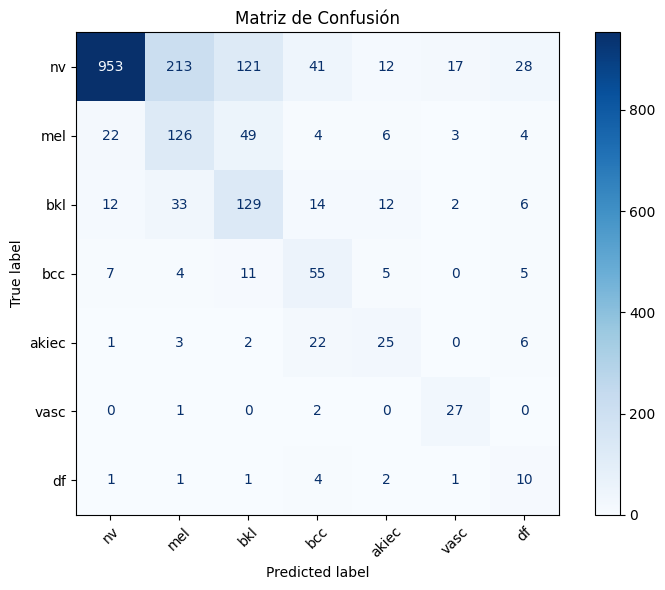

In [ ]:
train_gen, val_gen, test_gen = prepare_generators(df_train_over, df_val, df_test)

# Calcula class weights
weights = get_class_weights(df_train)

# Crea modelo
model = create_model()

# Entrena modelo
history = train_model(model, train_gen, val_gen, weights)

# Evalúa
test_model(model, test_gen)
plot_model_training_curve(history)